# Задание 3
## 1 Часть

In [25]:
import scipy.stats as sps
import numpy as np
import matplotlib.pyplot as plt
from time import time
from math import sqrt, pi

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

In [35]:
class WinerProcess:
    def __init__(self, precision=10000):
        self.__private_precision = precision
        self.__private_xi = np.array([sps.norm.rvs(size=precision+1)])
        self.__private_k = np.arange(1, precision+1)

    def __getitem__(self, times):
        #чтобы работать одинаково и с числом, и со списком    
        times=np.append([], times)
        #максимальный номер отрезка
        leftboard = int(max(times)/pi)
        if(leftboard >= len(self.__private_xi)):
        #генерация того, чего не хватает
            self.__private_xi = np.append(self.__private_xi, sps.norm.rvs(size=(self.__private_precision+1)*(leftboard-len(self.__private_xi)+1))).reshape(leftboard+1, self.__private_precision+1)
        return [self._X_t(i) for i in times]
    
    def _X_t(self, t):
        #номер отрезка
        leftboard = int(t/pi)
        realt = t - pi*leftboard 
        #склейка с предыдущими
        # для обеспечения непрерывности нужно прибавить к значению в t сумму значений в точках вида pi*n - чтобы значения в этих точках совпадали
        answer = np.dot(self.__private_xi[:leftboard, 0], np.arange(1, leftboard+1)) * sqrt(pi)
        # первое слагаемоеив сумме
        answer += self.__private_xi[leftboard][0]*realt/sqrt(pi)
        #оставшаяся сумма
        answer += sqrt(2/pi) * np.dot(np.sin(self.__private_k * t)/self.__private_k, self.__private_xi[leftboard][1:])
        return answer

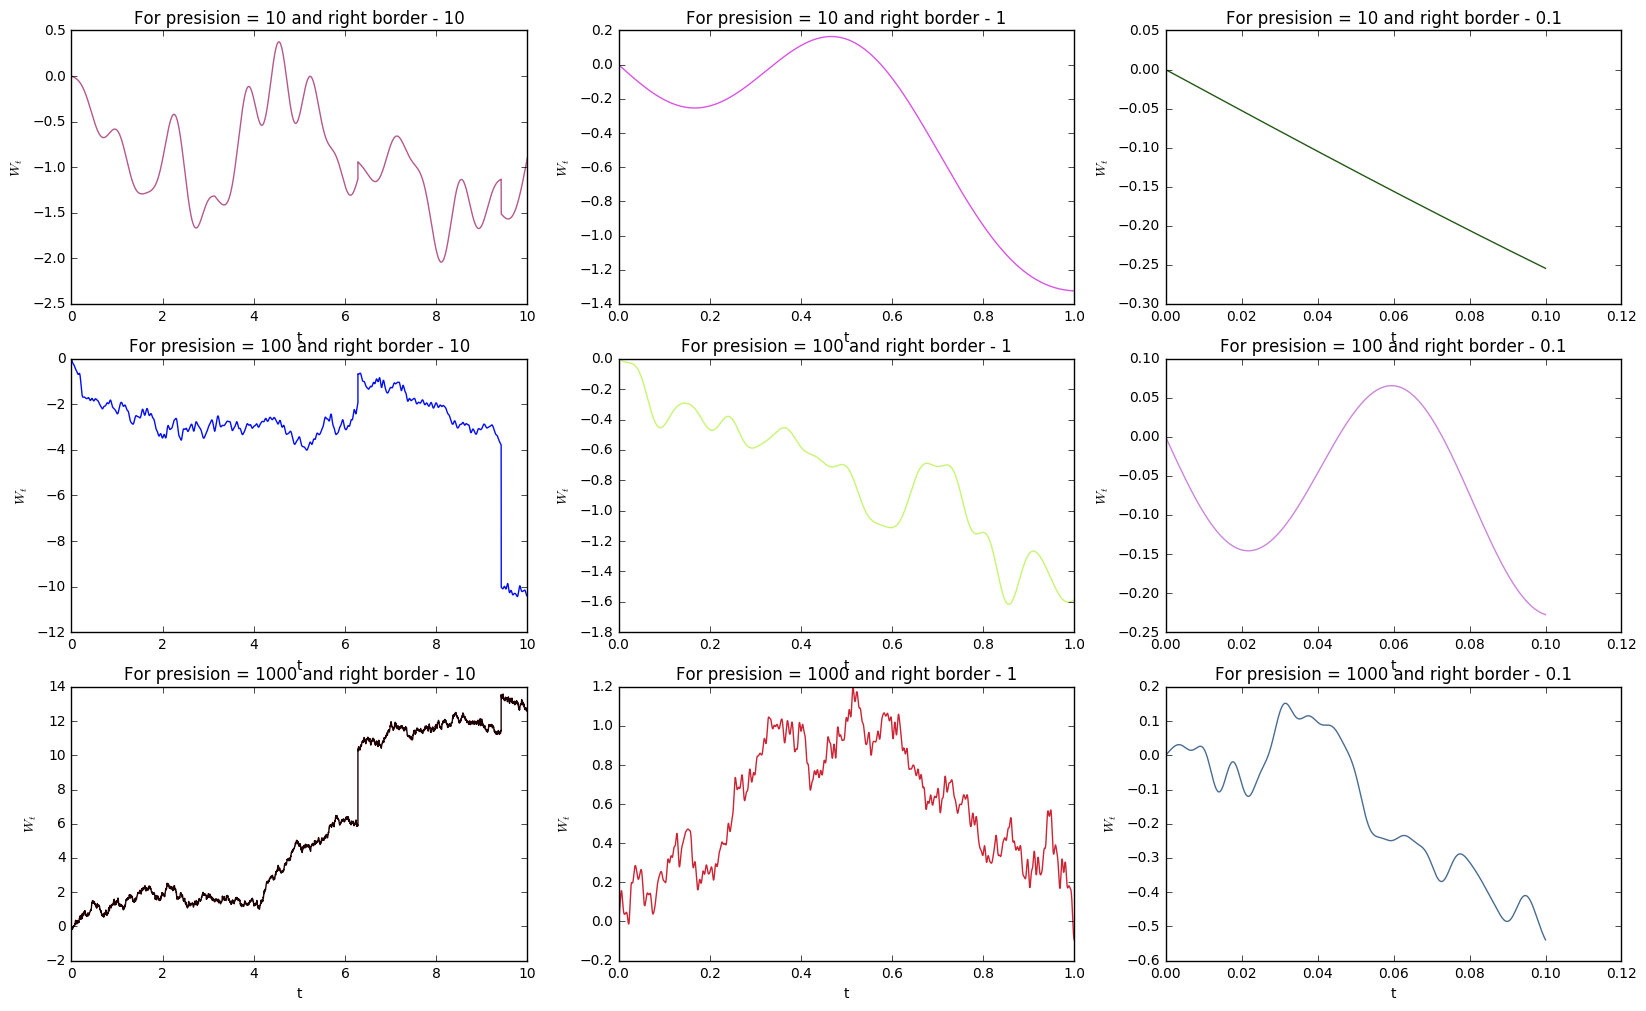

In [36]:
ns = [10, 100, 1000]
cuts = [[0, 10], [0, 1], [0, 0.1]]
plt.figure(figsize=(20, 12))
for i in [0, 1, 2]:
    for j in [0, 1, 2]:
        grid = np.linspace(0, cuts[j][1], 100000)
        wp = WinerProcess(precision=ns[i])
        traj = wp[grid]
        plt.subplot(3, 3, i * 3 + j + 1)
        plt.plot(grid, traj, color=np.random.rand(3), lw=1)
        plt.title('For presision = '+str(ns[i])+' and right border - '+str(cuts[j][1]))
        plt.xlabel('t')
        plt.ylabel(u'$W_t$')

Из полученных графиков видно, что чем больше слагаемых, тем менее гладкая траектория, и тем более это похоже на винеровский процесс, что логично, тк увеличивается точность и результат приближается к реальному. Также процесс становится менее гладким приувелицении длины отрезка, так как, чем ближе значения t, тем ближе значения их синусов. Поэтому, если мы хотим приблизить траекторию к действительности, но нет возможности увеличить количество слагаемых, можно увеличить размер отрезка, на котором проводятся вычисления.

#### Проблема: 
при вычислении значений для больших t в какой-то момент кончается память, так как мы вынуждены хранить все случайные величины для всех предыдущих отрезков - но если значения t заранее известны, то можно применить некоторые оптимизации - не хранить все(удалять данные для предыдущих отрезков) и не генерировать лишнее(для отрезков, в которые мы не попадаем). 

In [30]:
def winer_proccess_path(end_time, step, precision=10000):
    times = np.arange(0, end_time, step)
    values = np.zeros_like(times, dtype=float)
    #не обязательно все хранить
    #не обязательно так много генерировать(если times достаточно разреженный)
    
    #то, что нужно добавлять к значению на данном отрезке - дня обеспечения непрерывности
    mustbeadded = 0.
    #левая граница текущего отрезка
    leftboard = -1
    #список случайных величин для текущего отрезка
    xi = [0]
    i = 0
    
    k = np.arange(1, precision+1)
    
    for t in times:
        # начало отрезка, в котором находится t
        board = int(t/pi)
        # генерируем новые случайные величины
        if(board > leftboard):
            #xi_0 для пропущенных отрезков
            xi_0 = sps.norm.rvs(size = board-leftboard-1)
            #это будет нужно и всем последующим
            mustbeadded += np.dot(xi_0, np.arange(leftboard+1, board))*sqrt(pi)
            #добавляем значение предыдущего отрезка в т leftboard*pi
            mustbeadded += leftboard*xi[0]*sqrt(pi)
            
            #генерация нового списка xi
            xi = sps.norm.rvs(size = precision+1)
            
        #находимся в пределах отрезка, для которого св сгенерированы
        #вычисление значения
        values[i] = mustbeadded + xi[0]*t/sqrt(pi) + sqrt(2/pi)*np.dot(np.sin(k*t)/k, xi[1:])
        i +=1
    return times, values

In [31]:
%time times, values = winer_proccess_path(50000, 0.1)

CPU times: user 11min 55s, sys: 3.02 s, total: 11min 58s
Wall time: 12min 6s


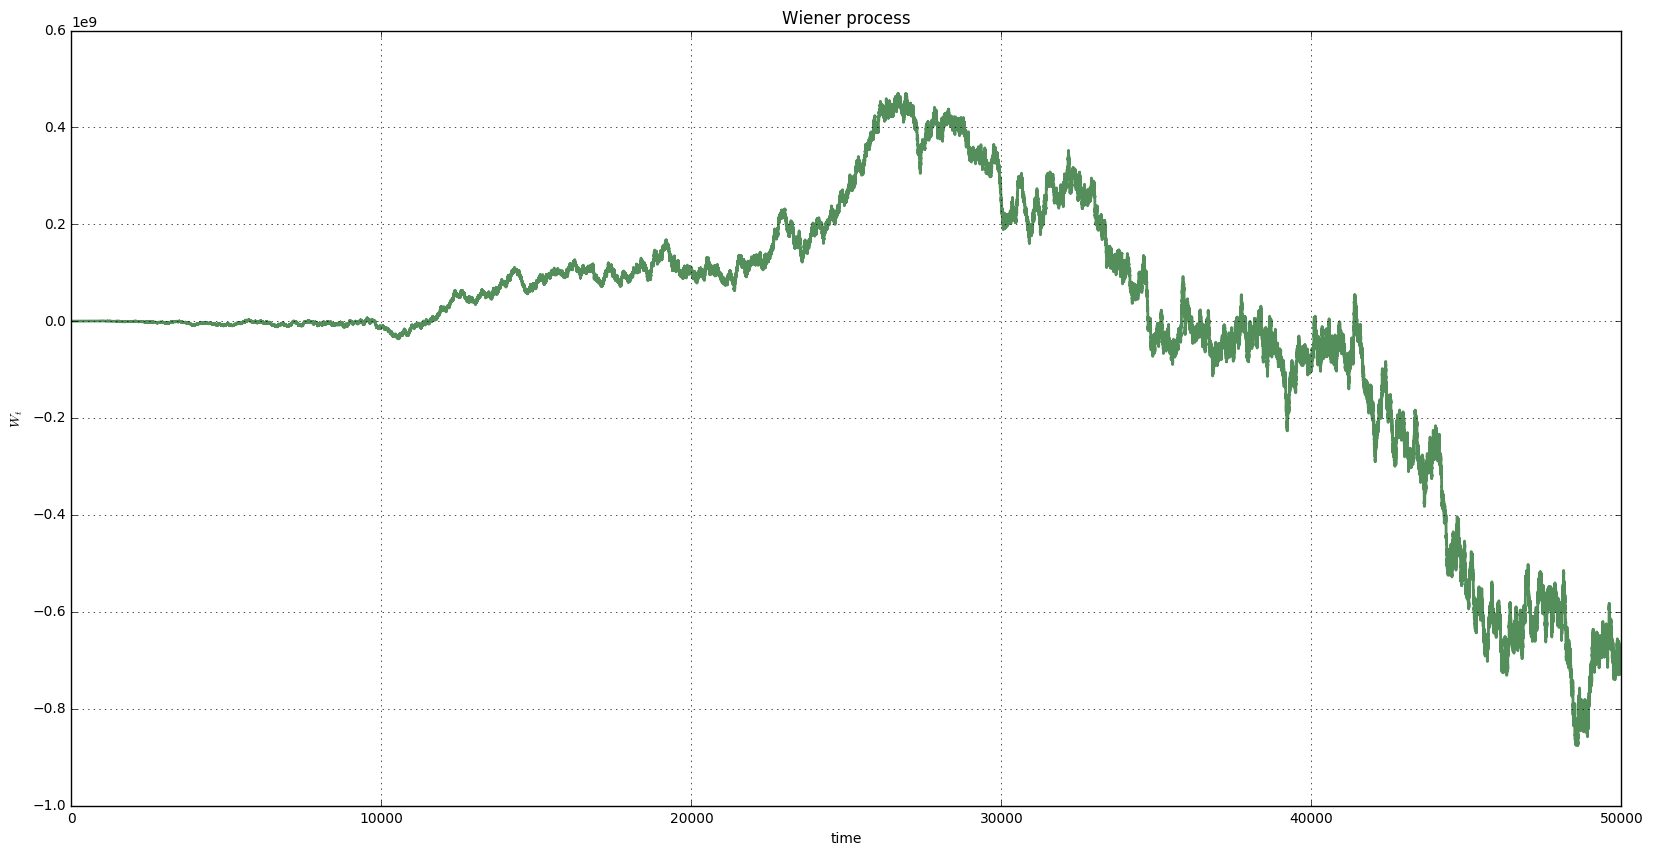

In [38]:
plt.figure(figsize=(20, 10))
plt.plot(times, values, lw=2, color=np.random.rand(3))
plt.grid()
plt.title('Wiener process')
plt.xlabel('time')
plt.ylabel(u'$W_t$')
plt.show()

## 2 Часть
Задача:
Поставить и проверить гипотезу о распределении $𝑋_𝑡$, где $𝑋_𝑡 -$ количество максимумов винеровского процесса на отрезке [0, 𝑡].

In [2]:
max_time = 20000
path_count = 50
t = np.arange(0, max_time, 0.1)
paths = np.zeros((path_count, 10 * max_time))

# Использую файлы с номерами 1, 3, 5, 7, 9
for i in np.arange(5):
    paths[i*10:(i+1)*10] = \
        np.loadtxt('winer_paths_{}.txt'.format(2*i+1))[:, :10 * max_time]

### Построение траекторий винеровского процесса

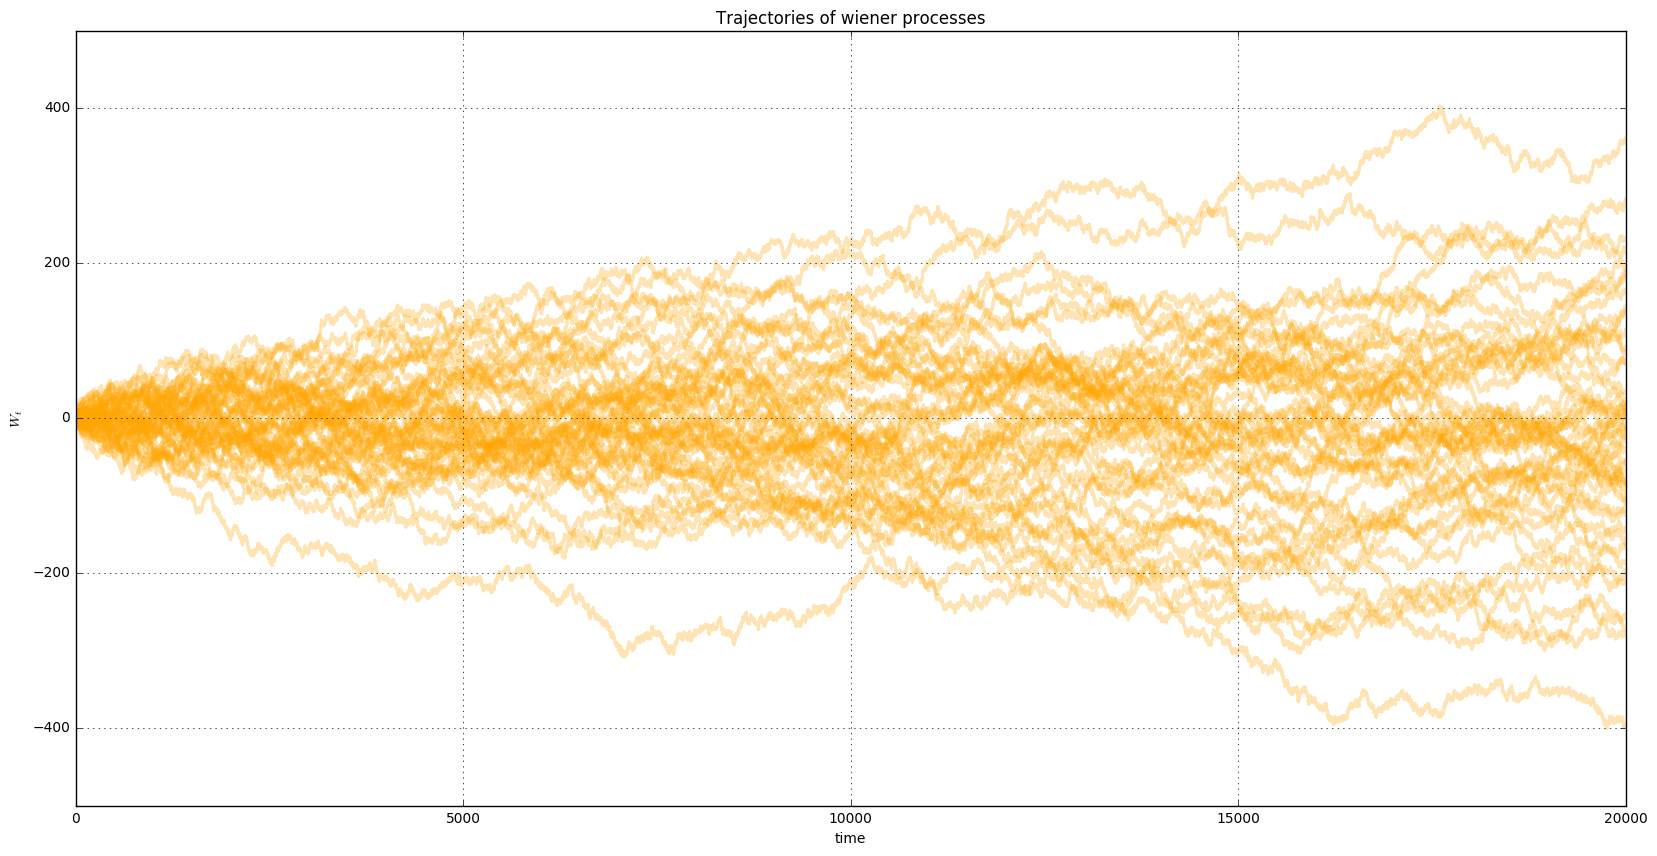

In [3]:
plt.figure(figsize=(20, 10))
for i in range(path_count):
    plt.plot(t, paths[i], lw=2, alpha=0.3, color='orange')
plt.grid()
plt.title('Trajectories of wiener processes')
plt.xlabel('time')
plt.ylabel(u'$W_t$')
plt.show()

Для моей задачи это не очень наглядно. Возьму несколько процессов и проведу для их траекторий максимумы на отрезках [0, t], а также отмечу точки, в которых достигаются максимумы (для наглядности еще приближу некоторые области)

In [21]:
def research(numproc):
    max1 = np.zeros(10*max_time)
    currmax = 0
    j = 0;
    for i in paths[numproc]:
        if(i > currmax):
            currmax = i
        max1[j] = currmax
        j += 1
    
    x = []
    y = []
    for i in np.arange(len(t)):
        if(paths[numproc][i] >= max1[i]):
            x.append(t[i])
            y.append(max1[i])
    
    plt.figure(figsize=(20, 10))
    plt.plot(t, paths[numproc], lw=2, alpha=0.3, color = 'purple', label = "wiener process")
    plt.plot(t, max1, lw=2, color='orange', label = "maximum")
    plt.scatter(x, y, color='red', label = "point of maximum")
    plt.legend()
    plt.title('Trajectories of wiener processes')
    plt.xlabel('time')
    plt.ylabel(u'$W_t$')
    plt.xlim((0, 20000))
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(20, 10))
    plt.plot(t, paths[numproc], lw=2, alpha=0.3, color = 'purple', label = "wiener process")
    plt.plot(t, max1, lw=2, color='orange', label = "maximum")
    plt.scatter(x, y, color='red', label = "point of maximum")
    plt.xlim((0, 10))
    plt.ylim((-5, 6))
    plt.title('Trajectories of wiener processes')
    plt.xlabel('time')
    plt.ylabel(u'$W_t$')
    plt.grid()
    plt.show()

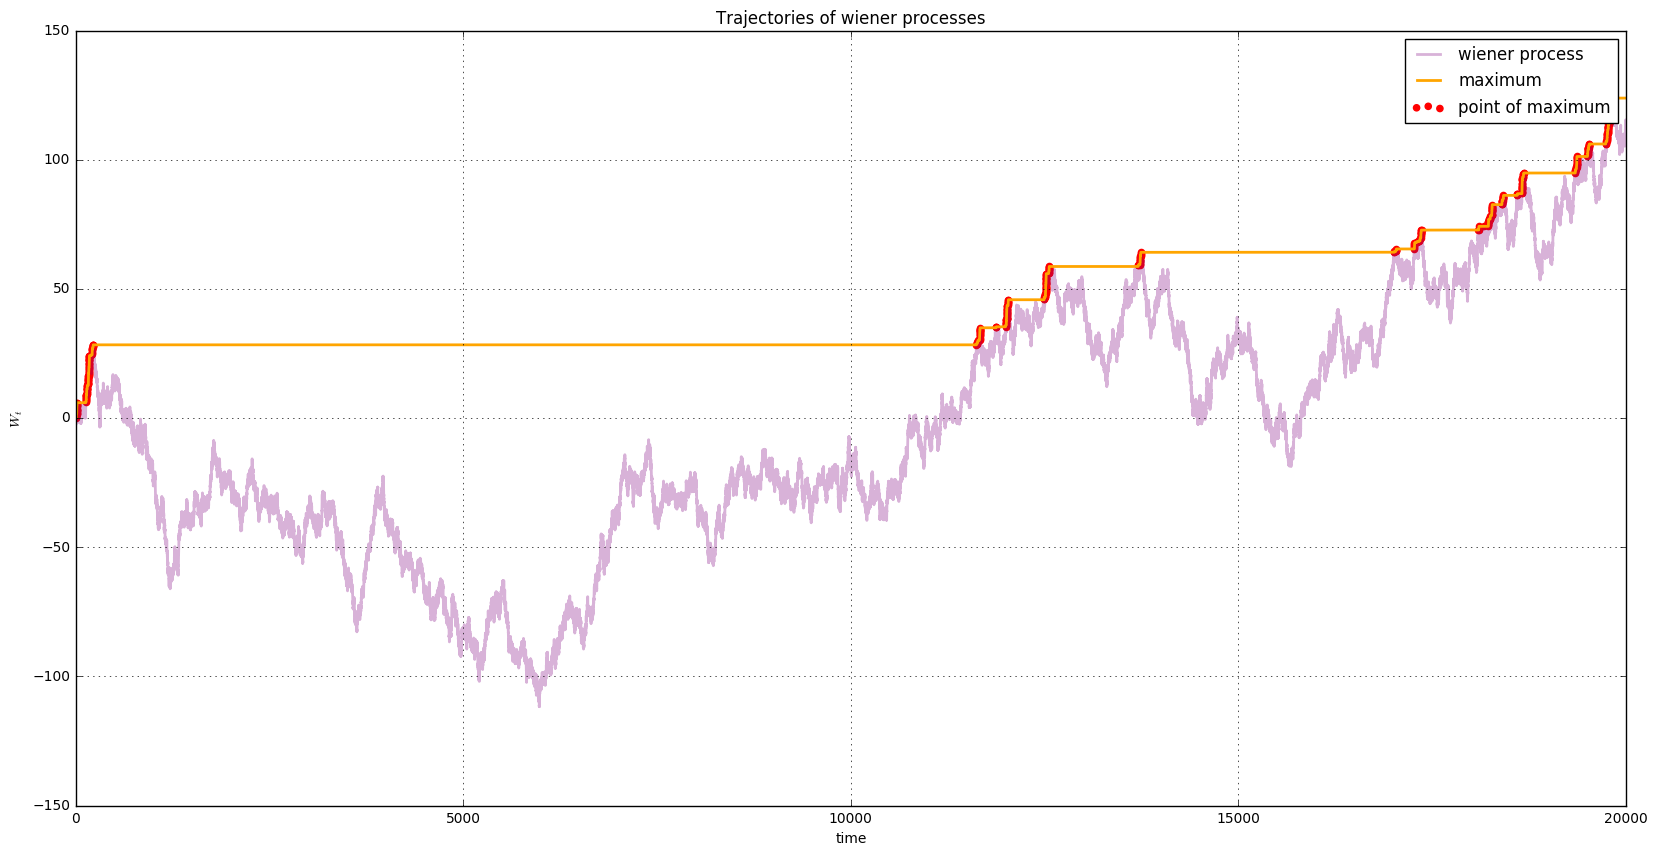

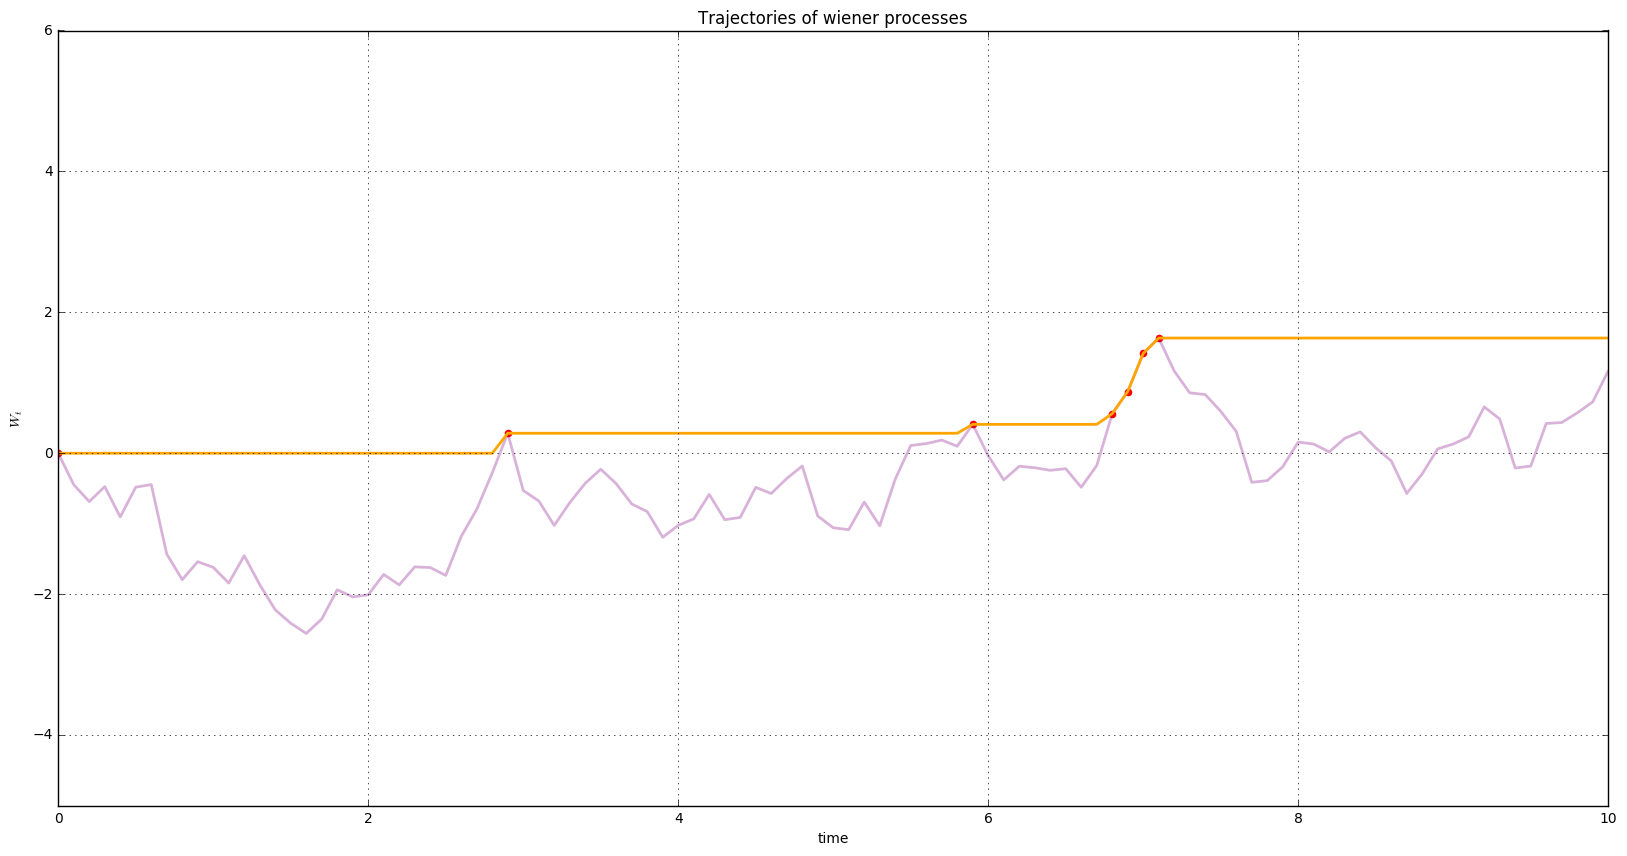

In [22]:
research(5)

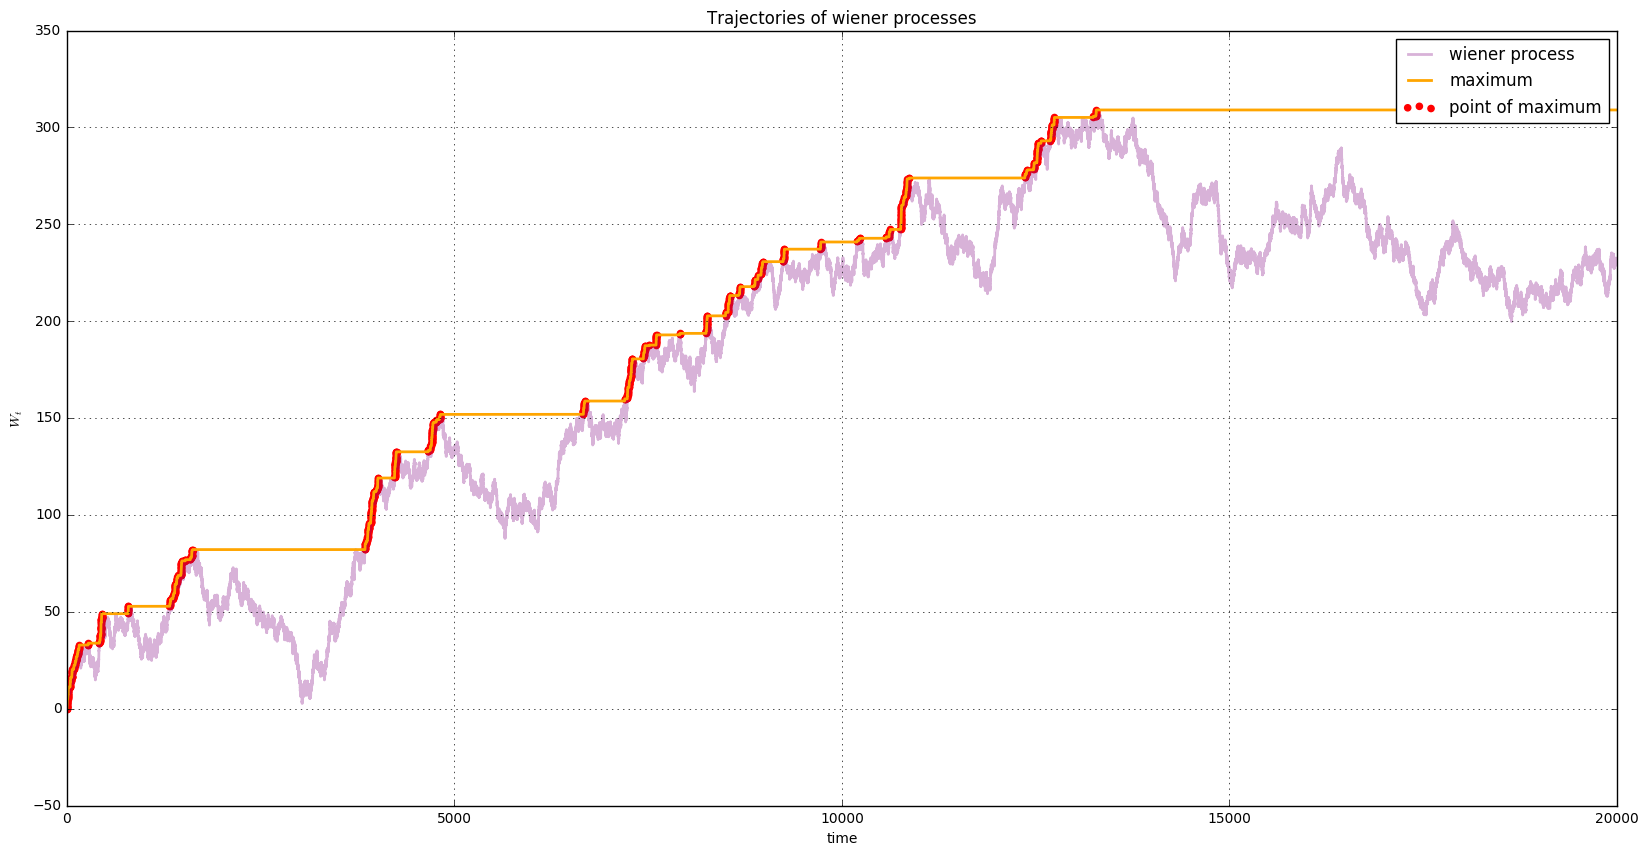

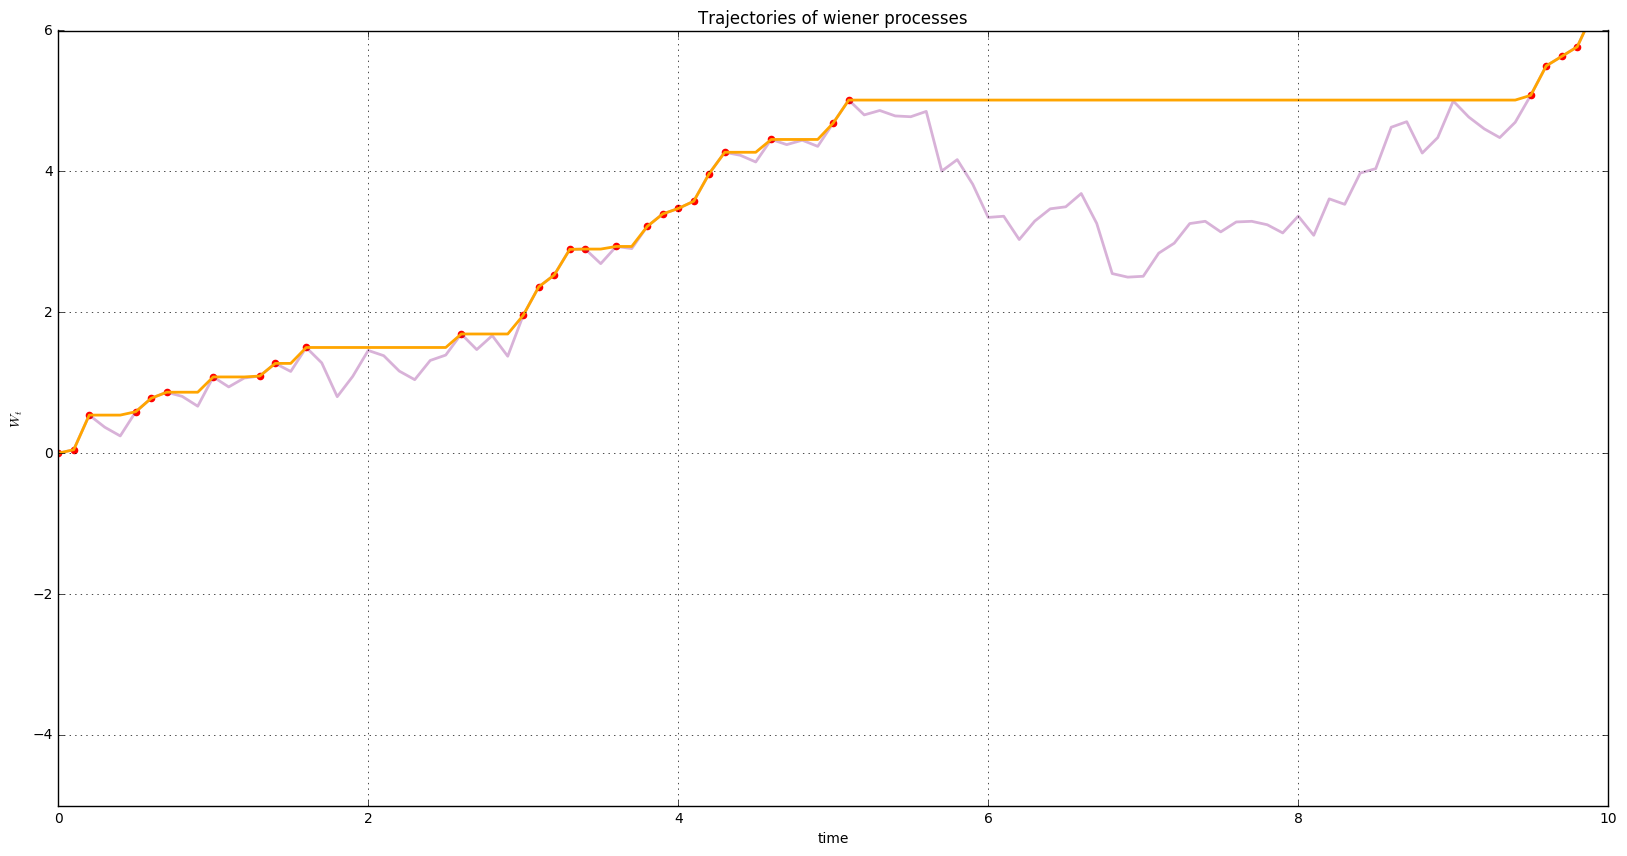

In [23]:
research(37)

На графиках видно, что на точках данной выборки повторно максимум не достигается, проверю это. Для каждого t из выборки моментов времени посчитаю количество достижений максимума на отрезке [1, t].

In [7]:
numofmax = np.ones_like(paths)
for i in np.arange(len(paths)):
    max0i = -1
    for j in np.arange(len(paths[i])):
        if(paths[i][j] == max0i):
            numofmax[i][j] += 1
        if(paths[i][j] > max0i):
            max0i = paths[i][j]
            

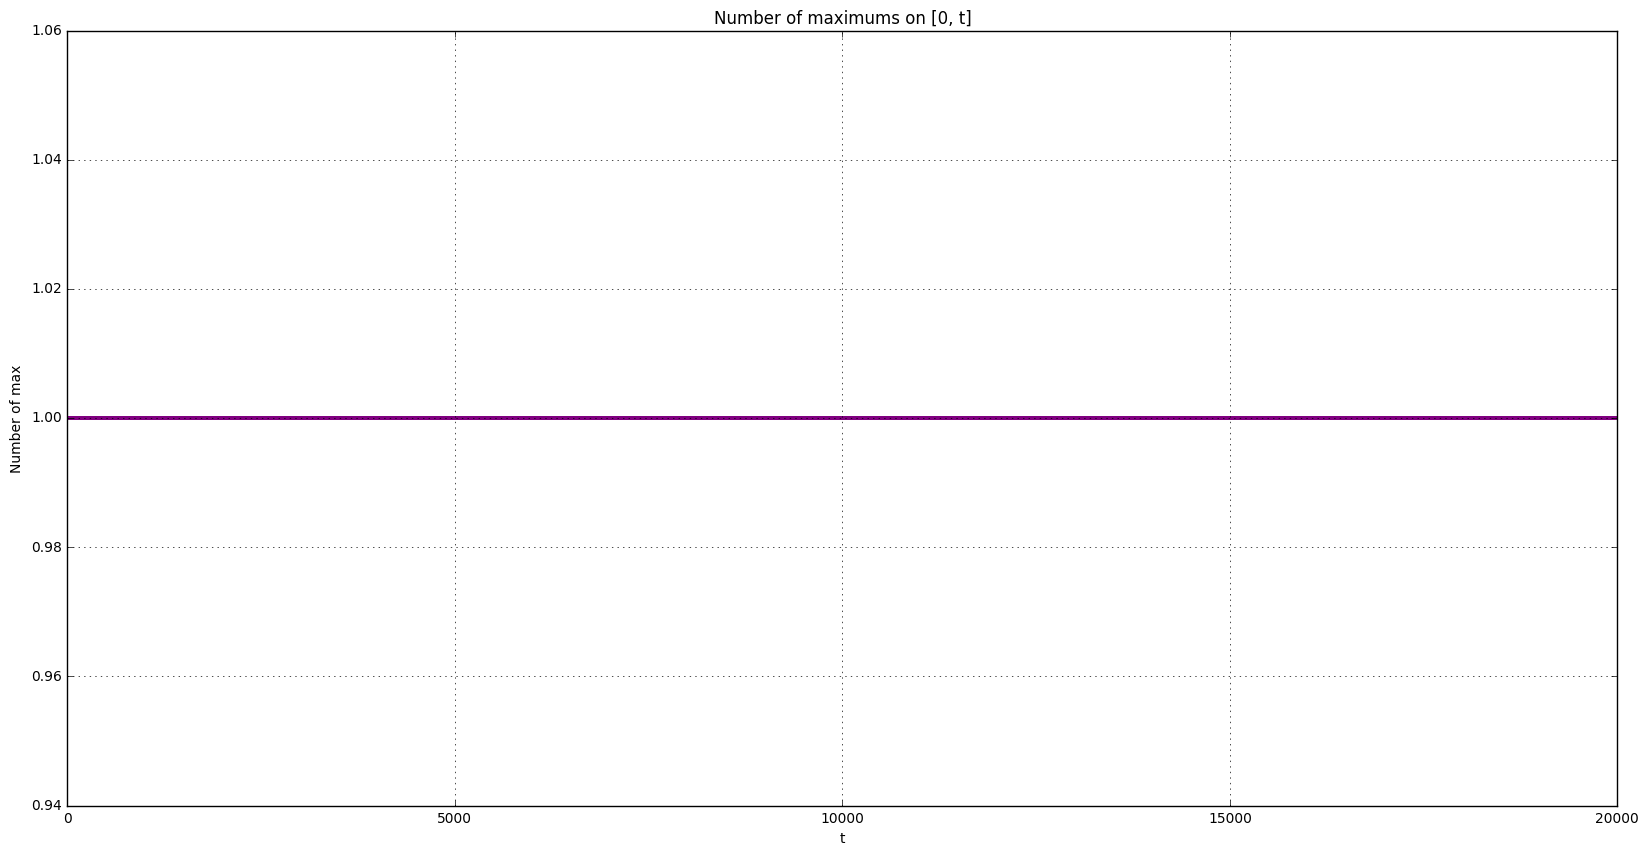

In [8]:
plt.figure(figsize=(20, 10))
for i in range(path_count):
    plt.plot(t, numofmax[i], lw=2, alpha=0.3, color='purple')
plt.grid()
plt.title('Number of maximums on [0, t]')
plt.xlabel('t')
plt.ylabel('Number of max')
plt.show()

На данной выборке получается, что на любом отрезке вида [0, t] есть всего один максимум, в рамках данной выборки более детально исследовать нельзя, поэтому логично предположить:
#### Гипотеза - $X_t = 1$ почти наверное, где $X_t$ - количество максимумов винеровского процесса на отрезке [0, t]

### Доказательство гипотезы

Покажем, что для любого отрезка [1, x] максимум достигается всего 1 раз.
Предположим противное, что эквивалентно $\exists a<b<c<d \in Q : sup_{t \in [a, b]} W_t = sup_{t \in [c, d]} W_t$
Поэтому достаточно проверить, что для фиксированных  a, b, c, d верояность этого события равна нулю.
Введем $B(s) = W_{c+s} - W_{c} $. Тк $W_t$ имеет независимые приращения, по B(s) не зависит от всех $W_t, t<c$, в частности при $t \in [a, b]$.
$$P(sup_{t \in [a, b]} W_t = sup_{t \in [c, d]} W_t) = EI(sup_{t \in [a, b]} W_t = W_c + sup_{s \in [0, d-c]} B_s) = 
\int_{R^2} I(x-y = W_c) dp(x, y) $$ Так $W_t$ и $B_s$ независимы, то x и y можно разделить, W_c - константа, поэтому получается $$ \int_{-\infty}^{+\infty}dp_1(x)\int_{-\infty}^{+\infty} I(x-y = W_c) dp_2(y) = \int_{-\infty}^{+\infty}dp_1(x)\int_{x-W_c}^{x-W_c} dp_2(y) = 0$$
Таким образом, доказано что $P(X_t=1) = 1$

In [ ]:
from v import WinerProccess, winer_proccess_path